In [1]:
import tensorflow as tf
import pandas as pd
import math
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [2]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [4]:
data_sitcoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 5 to 6040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1202 non-null   object 
 1   label   1202 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.2+ KB


Set Sitcoms dataset variables

In [5]:
subset_size = len(data_sitcoms.index)
testing_size = int(subset_size * 0.2)
validation_size = testing_size
shuffle_size = subset_size - validation_size
data_batch_size = 16

Shuffle data, set train data, set test data

In [6]:
data = data_sitcoms.sample(frac=1).reset_index(drop=True)
train_data = data.head(subset_size - testing_size)
test_data = data.tail(testing_size)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:],
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

In [8]:
validate_dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

In [10]:
text_vocab_dataset = tf.data.Dataset.from_tensor_slices(train_data['text'])

Set training variables

In [11]:
epochs = 10

##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 1024
max_length = 120

Initialize and configure WandB graphing library

In [12]:
wandb.init(project="sarcasmscanner", entity="awesomepossum")

wandb.config = {
    "epochs": epochs,
    "vocab_size": vocab_size,
    "embedding_dim": embedding_dim,
    "max_sentence_word_length": max_length,
    "batch_size": data_batch_size,
    "subset_size": subset_size,
    "training_size": subset_size - testing_size - validation_size,
    "testing_size": testing_size,
    "validation_size": validation_size,
    "dataset": "sitcoms",
    "architecture": "LSTM"
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrtyc4 (awesomepossum). Use `wandb login --relogin` to force relogin


Create text vectorization layer, create vocabulary

In [13]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text_vocab_dataset.batch(data_batch_size))

Create the model

In [14]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 120)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 120, 1024)         10240000  
                                                                 
 bidirectional (Bidirectiona  (None, 120, 128)         557568    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

Train the model

In [15]:
history = model.fit(x=train_dataset,
                        validation_data=validate_dataset,
                        epochs=epochs,
                        callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5069

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best)... Done. 0.8s


46/46 [==============================] - 47s 1s/step - loss: 0.6935 - accuracy: 0.5069 - val_loss: 0.6866 - val_accuracy: 0.5792
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6634

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\wandb\run-20221015_194556-2rdl9i7j\files\model-best)... Done. 1.0s


46/46 [==============================] - 45s 986ms/step - loss: 0.6528 - accuracy: 0.6634 - val_loss: 0.6494 - val_accuracy: 0.6417
Epoch 3/10
46/46 [==============================] - 6s 121ms/step - loss: 0.4109 - accuracy: 0.8366 - val_loss: 0.8119 - val_accuracy: 0.5917
Epoch 4/10
46/46 [==============================] - 5s 112ms/step - loss: 0.1711 - accuracy: 0.9515 - val_loss: 1.3688 - val_accuracy: 0.5292
Epoch 5/10
46/46 [==============================] - 5s 112ms/step - loss: 0.0986 - accuracy: 0.9668 - val_loss: 1.5161 - val_accuracy: 0.5542
Epoch 6/10
46/46 [==============================] - 5s 109ms/step - loss: 0.0476 - accuracy: 0.9875 - val_loss: 1.6787 - val_accuracy: 0.5250
Epoch 7/10
46/46 [==============================] - 5s 114ms/step - loss: 0.0391 - accuracy: 0.9903 - val_loss: 1.7559 - val_accuracy: 0.5458
Epoch 8/10
46/46 [==============================] - 5s 110ms/step - loss: 0.0344 - accuracy: 0.9889 - val_loss: 1.6113 - val_accuracy: 0.5667
Epoch 9/10
46/46

Test the model

In [16]:
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 0s 51ms/step - loss: 1.8544 - accuracy: 0.5583
Loss: 1.8544219732284546
Accuracy: 0.5583333373069763


Plot the accuracy and loss over time

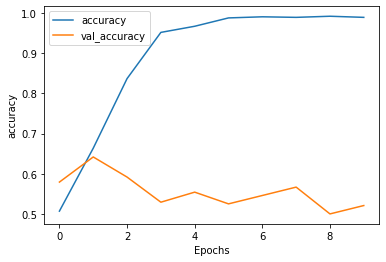

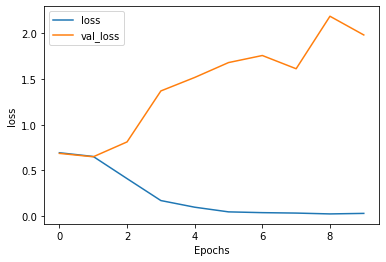

In [17]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

Export for inference

In [18]:
saved_model_path = './model_saves/mustard_lstm/'
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/mustard_lstm/assets


INFO:tensorflow:Assets written to: ./model_saves/mustard_lstm/assets


Reload and test inference

In [19]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [20]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.7279666  : rounded:  1
input:  Well, what a surprise.  : score:  0.5019886  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.5630474  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.5020925  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.51933545  : rounded:  1

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.7279666  : rounded:  1
input:  Well, what a surprise.  : score:  0.5019886  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.5630474  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.5020925  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.51933545  : rounded:  1



Set training variables

In [21]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

Download preprocessing and encoding model layers from tensorflow hub

In [22]:
preprocessing_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', 
    name='preprocessing'
)

bert_encoder = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', 
    trainable=True, 
    name='BERT_encoder'
)

Create model using the BERT encoder

In [23]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = bert_encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

Sanity check of model

In [24]:
text_test = ["Please, keep talking. I always yawn when I am interested."]
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5291322]], shape=(1, 1), dtype=float32)


In [25]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Set loss function

In [26]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Create optimizer

In [27]:
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

Compile model

In [28]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train model

In [29]:
history = classifier_model.fit(x=train_dataset,
                               validation_data=validate_dataset,
                               epochs=epochs)

Epoch 1/10
46/46 [==============================] - 18s 322ms/step - loss: 0.7297 - binary_accuracy: 0.5042 - val_loss: 0.6509 - val_binary_accuracy: 0.5875
Epoch 2/10
46/46 [==============================] - 13s 287ms/step - loss: 0.6547 - binary_accuracy: 0.5956 - val_loss: 0.6388 - val_binary_accuracy: 0.5750
Epoch 3/10
46/46 [==============================] - 13s 287ms/step - loss: 0.5831 - binary_accuracy: 0.6662 - val_loss: 0.6427 - val_binary_accuracy: 0.5458
Epoch 4/10
46/46 [==============================] - 13s 286ms/step - loss: 0.5086 - binary_accuracy: 0.7382 - val_loss: 0.6475 - val_binary_accuracy: 0.5542
Epoch 5/10
46/46 [==============================] - 13s 283ms/step - loss: 0.4250 - binary_accuracy: 0.7936 - val_loss: 0.7374 - val_binary_accuracy: 0.5667
Epoch 6/10
46/46 [==============================] - 13s 284ms/step - loss: 0.3428 - binary_accuracy: 0.8546 - val_loss: 0.7036 - val_binary_accuracy: 0.5917
Epoch 7/10
46/46 [==============================] - 13s 29

Test model

In [30]:
loss, accuracy = classifier_model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

ValueError: Exception encountered when calling layer "preprocessing" "                 f"(type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * <tf.Tensor 'inputs:0' shape=() dtype=string>
    * False
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * True
    * None
  Keyword arguments: {}

Call arguments received by layer "preprocessing" "                 f"(type KerasLayer):
  • inputs=tf.Tensor(shape=(), dtype=string)
  • training=False

Plot accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


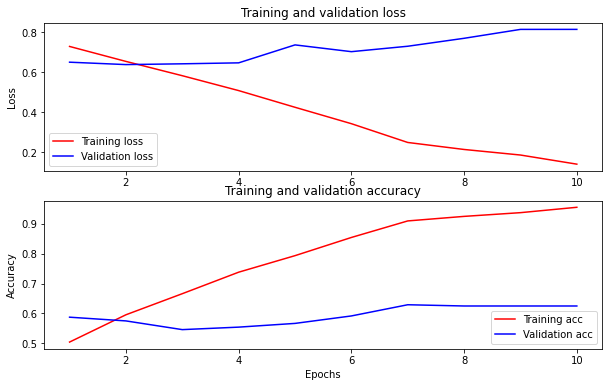

In [31]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Export for inference

In [32]:
saved_model_path = './model_saves/bert_v1/'
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


Reload and test inference

In [33]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [34]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.6116986  : rounded:  1
input:  Well, what a surprise.  : score:  0.009469548  : rounded:  0
input:  Really, Sherlock? No! You are clever.  : score:  0.987211  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.723083  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.07948795  : rounded:  0

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.6116986  : rounded:  1
input:  Well, what a surprise.  : score:  0.009469548  : rounded:  0
input:  Really, Sherlock? No! You are clever.  : score:  0.987211  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.723083  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.07948795  : rounded:  0

